Here we will demonstrate using a WRF datafile with the Xarray module and the manipulations necessary to get the dataset into CF conventions understood by Xarray.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from ngallery_utils import DATASETS

Take a look at the WRF dataset

In [2]:
path = DATASETS.fetch("T2_RR_F_2014_08.nc")
ds_wrf = xr.open_dataset(path)
ds_wrf

<xarray.Dataset>
Dimensions:      (Time: 720, south_north: 159, west_east: 159)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    PREC_ACC_NC  (Time, south_north, west_east) float32 ...
    T2           (Time, south_north, west_east) float32 ...
    Times        (Time) |S19 ...
    U10          (Time, south_north, west_east) float32 ...
    V10          (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                         1
    OPT_RAD:                         3
    OPT_ALB:                         2
    OPT_SNF:                         4


# Problem #1: Time in bytes.

Currently our time information is stored in the 'Times' variable in string byte formatting. We need to create a time coordinate in datetime64 formatting.

Let's take a look at our time variable so far:

In [3]:
da_time = ds_wrf['Times']
da_time

<xarray.DataArray 'Times' (Time: 720)>
array([b'2014-08-01_00:00:00', b'2014-08-01_01:00:00', b'2014-08-01_02:00:00',
       ..., b'2014-08-30_21:00:00', b'2014-08-30_22:00:00',
       b'2014-08-30_23:00:00'], dtype='|S19')
Dimensions without coordinates: Time

If the time coordinate is not in datetime64 formatting you cannot use some of the time-aware functionality in Xarray (see blog post [here](https://ncar.github.io/xdev/posts/time/)).

For example, the `xarray.DataArray.sel` functionality will fail.
```
prc_aug01_aug08 = ds_wrf['PREC_ACC_NC'].sel(Times=slice('2014-08-01', '2014-08-08'))
```
returns the error:
```
ValueError: dimensions or multi-index levels ['Times'] do not exist
```

This isn't that surprising. `.sel` works along a dimension, and our variable `Times` is just that, a variable, with dimension `Time`. If we use `.sel` along the `Time` dimension we see:

```
prc_aug01_aug08 = ds_wrf['PREC_ACC_NC'].sel(Time=slice('2014-08-01', '2015-08-08'))
```
returns the error:
```
TypeError: 'str' object cannot be interpreted as an integer
```

This is because our `Time` dimension is an index list.

In [4]:
ds_wrf['Time']

<xarray.DataArray 'Time' (Time: 720)>
array([  0,   1,   2, ..., 717, 718, 719])
Dimensions without coordinates: Time

So let's convert our `Times` variable to datetime64 using `pandas.to_datetime`:

```
time_datetime = pd.to_datetime(da_time)
```
returns the error:
```
TypeError: <class 'bytes'> is not convertible to datetime
```

Available arguments for `to_datetime` are: 
- integer
- float
- string
- datetime
- list
- tuple
- 1-d array
- Series

So let's convert to a string!

In [5]:
time_strs = [str(i.values)[1:] for i in da_time]
time_strs

["'2014-08-01_00:00:00'",
 "'2014-08-01_01:00:00'",
 "'2014-08-01_02:00:00'",
 "'2014-08-01_03:00:00'",
 "'2014-08-01_04:00:00'",
 "'2014-08-01_05:00:00'",
 "'2014-08-01_06:00:00'",
 "'2014-08-01_07:00:00'",
 "'2014-08-01_08:00:00'",
 "'2014-08-01_09:00:00'",
 "'2014-08-01_10:00:00'",
 "'2014-08-01_11:00:00'",
 "'2014-08-01_12:00:00'",
 "'2014-08-01_13:00:00'",
 "'2014-08-01_14:00:00'",
 "'2014-08-01_15:00:00'",
 "'2014-08-01_16:00:00'",
 "'2014-08-01_17:00:00'",
 "'2014-08-01_18:00:00'",
 "'2014-08-01_19:00:00'",
 "'2014-08-01_20:00:00'",
 "'2014-08-01_21:00:00'",
 "'2014-08-01_22:00:00'",
 "'2014-08-01_23:00:00'",
 "'2014-08-02_00:00:00'",
 "'2014-08-02_01:00:00'",
 "'2014-08-02_02:00:00'",
 "'2014-08-02_03:00:00'",
 "'2014-08-02_04:00:00'",
 "'2014-08-02_05:00:00'",
 "'2014-08-02_06:00:00'",
 "'2014-08-02_07:00:00'",
 "'2014-08-02_08:00:00'",
 "'2014-08-02_09:00:00'",
 "'2014-08-02_10:00:00'",
 "'2014-08-02_11:00:00'",
 "'2014-08-02_12:00:00'",
 "'2014-08-02_13:00:00'",
 "'2014-08-0

But it isn't that simple!
```
time_datetime = pd.to_datetime(time_strs)
```

returns the error:
```
ValueError: ('Unknown string format:', "'2014-08-01_00:00:00'")
```

We need to remove those pesky underscores.

In [6]:
time_strs = [str(i.values)[1:].replace("_"," ") for i in da_time]
time_strs

["'2014-08-01 00:00:00'",
 "'2014-08-01 01:00:00'",
 "'2014-08-01 02:00:00'",
 "'2014-08-01 03:00:00'",
 "'2014-08-01 04:00:00'",
 "'2014-08-01 05:00:00'",
 "'2014-08-01 06:00:00'",
 "'2014-08-01 07:00:00'",
 "'2014-08-01 08:00:00'",
 "'2014-08-01 09:00:00'",
 "'2014-08-01 10:00:00'",
 "'2014-08-01 11:00:00'",
 "'2014-08-01 12:00:00'",
 "'2014-08-01 13:00:00'",
 "'2014-08-01 14:00:00'",
 "'2014-08-01 15:00:00'",
 "'2014-08-01 16:00:00'",
 "'2014-08-01 17:00:00'",
 "'2014-08-01 18:00:00'",
 "'2014-08-01 19:00:00'",
 "'2014-08-01 20:00:00'",
 "'2014-08-01 21:00:00'",
 "'2014-08-01 22:00:00'",
 "'2014-08-01 23:00:00'",
 "'2014-08-02 00:00:00'",
 "'2014-08-02 01:00:00'",
 "'2014-08-02 02:00:00'",
 "'2014-08-02 03:00:00'",
 "'2014-08-02 04:00:00'",
 "'2014-08-02 05:00:00'",
 "'2014-08-02 06:00:00'",
 "'2014-08-02 07:00:00'",
 "'2014-08-02 08:00:00'",
 "'2014-08-02 09:00:00'",
 "'2014-08-02 10:00:00'",
 "'2014-08-02 11:00:00'",
 "'2014-08-02 12:00:00'",
 "'2014-08-02 13:00:00'",
 "'2014-08-0

In [7]:
time_datetime = pd.to_datetime(time_strs)
time_datetime

DatetimeIndex(['2014-08-01 00:00:00', '2014-08-01 01:00:00',
               '2014-08-01 02:00:00', '2014-08-01 03:00:00',
               '2014-08-01 04:00:00', '2014-08-01 05:00:00',
               '2014-08-01 06:00:00', '2014-08-01 07:00:00',
               '2014-08-01 08:00:00', '2014-08-01 09:00:00',
               ...
               '2014-08-30 14:00:00', '2014-08-30 15:00:00',
               '2014-08-30 16:00:00', '2014-08-30 17:00:00',
               '2014-08-30 18:00:00', '2014-08-30 19:00:00',
               '2014-08-30 20:00:00', '2014-08-30 21:00:00',
               '2014-08-30 22:00:00', '2014-08-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq=None)

Now we have our time values. Let's rename our dimension `Time` to `time` to match conventions, assign our new `time` coordinate, and drop the `Times` variable.

In [8]:
ds_wrf_timedim = ds_wrf.rename({'Time':'time'})
ds_wrf_timedim

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 720, west_east: 159)
Dimensions without coordinates: south_north, time, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    Times        (time) |S19 b'2014-08-01_00:00:00' ... b'2014-08-30_23:00:00'
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                         1
    OPT_RAD:                         3
    OPT_ALB:                    

In [9]:
ds_wrf_timecoord = ds_wrf_timedim.assign(time=time_datetime)
ds_wrf_timecoord

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 720, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    Times        (time) |S19 b'2014-08-01_00:00:00' ... b'2014-08-30_23:00:00'
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                 

In [10]:
ds_wrf_dropped_Times = ds_wrf_timecoord.drop('Times')
ds_wrf_dropped_Times

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 720, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                         1
    OPT_RAD:                         3
    OPT_ALB:                  

A review of the steps for dealing with WRF time:
```
da_time = ds_wrf['Times']
time_strs = [str(i.values)[1:].replace("_"," ") for i in da_time]
time_datetime = pd.to_datetime(time_strs)

ds_wrf_timedim = ds_wrf.rename({'Time':'time'})
ds_wrf_timecoord = ds_wrf_timedim.assign(time=time_datetime)
ds_wrf_dropped_Times = ds_wrf_timecoord.drop('Times')
```

# Problem #2: NO COORDINATES

We need to pull in our lat/lon information from a separate geo file.

In [11]:
path = DATASETS.fetch("wrfinput_d02")
ds_geo = xr.open_dataset(path)
ds_geo

(Time) |S19 ...
    LU_INDEX              (Time, south_north, west_east) float32 ...
    ZNU                   (Time, bottom_top) float32 ...
    ZNW                   (Time, bottom_top_stag) float32 ...
    ZS                    (Time, soil_layers_stag) float32 ...
    DZS                   (Time, soil_layers_stag) float32 ...
    VAR_SSO               (Time, south_north, west_east) float32 ...
    U                     (Time, bottom_top, south_north, west_east_stag) float32 ...
    V                     (Time, bottom_top, south_north_stag, west_east) float32 ...
    W                     (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB                   (Time, bottom_top_stag, south_north, west_east) float32 ...
    T                     (Time, bottom_top, south_north, west_east) float32 ...
    T_INIT                (Time, bottom_top, south_north, west_east) float32 ...
    MU                    (Time, south_north, west_east) float32 ...
    MUB                   (Time, south_north, west_east) float32 ...
    P                     (Time, bottom_top, south_north, west_east) float32 ...
    PB                    (Time, bottom_top, south_north, west_east) float32 ...
    FNM                   (Time, bottom_top) float32 ...
    FNP                   (Time, bottom_top) float32 ...
    RDNW                  (Time, bottom_top) float32 ...
    RDN                   (Time, bottom_top) float32 ...
    DNW                   (Time, bottom_top) float32 ...
    DN                    (Time, bottom_top) float32 ...
    T_BASE                (Time, bottom_top) float32 ...
    CFN                   (Time) float32 ...
    CFN1                  (Time) float32 ...
    STEP_NUMBER           (Time) int32 ...
    THIS_IS_AN_IDEAL_RUN  (Time) int32 ...
    P_HYD                 (Time, bottom_top, south_north, west_east) float32 ...
    Q2                    (Time, south_north, west_east) float32 ...
    T2                    (Time, south_north, west_east) float32 ...
    TH2                   (Time, south_north, west_east) float32 ...
    PSFC                  (Time, south_north, west_east) float32 ...
    U10                   (Time, south_north, west_east) float32 ...
    V10                   (Time, south_north, west_east) float32 ...
    RDX                   (Time) float32 ...
    RDY                   (Time) float32 ...
    DTS                   (Time) float32 ...
    DTSEPS                (Time) float32 ...
    RESM                  (Time) float32 ...
    ZETATOP               (Time) float32 ...
    CF1                   (Time) float32 ...
    CF2                   (Time) float32 ...
    CF3                   (Time) float32 ...
    QVAPOR                (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD                (Time, bottom_top, south_north, west_east) float32 ...
    QRAIN                 (Time, bottom_top, south_north, west_east) float32 ...
    QICE                  (Time, bottom_top, south_north, west_east) float32 ...
    QSNOW                 (Time, bottom_top, south_north, west_east) float32 ...
    QGRAUP                (Time, bottom_top, south_north, west_east) float32 ...
    QNICE                 (Time, bottom_top, south_north, west_east) float32 ...
    QNRAIN                (Time, bottom_top, south_north, west_east) float32 ...
    QNCLOUD               (Time, bottom_top, south_north, west_east) float32 ...
    QNWFA                 (Time, bottom_top, south_north, west_east) float32 ...
    QNIFA                 (Time, bottom_top, south_north, west_east) float32 ...
    FCX                   (Time, DIM0009) float32 ...
    GCX                   (Time, DIM0009) float32 ...
    DTBC                  (Time) float32 ...
    TOPOSLPX              (Time, south_north, west_east) float32 ...
    TOPOSLPY              (Time, south_north, west_east) float32 ...
    SHDMAX                (Time, south_north, west_e

What are our coordinates here? 
 - XLAT and XLONG -- these are our Latitude and Longitude values
 - XLAT_U and XLONG_U -- Lat and Long with a staggered west-east grid
 - XLAT_V and XLONG_V -- Lat and Long with a staggered north-south grid
 
We're going to use `XLAT` and `XLONG`.

In [12]:
ds_geo.coords['XLAT']

<xarray.DataArray 'XLAT' (Time: 1, south_north: 159, west_east: 159)>
array([[[59.699203, 59.699192, ..., 59.677734, 59.677475],
        [59.707745, 59.707737, ..., 59.68627 , 59.686012],
        ...,
        [61.03416 , 61.034157, ..., 61.012253, 61.01199 ],
        [61.042618, 61.04261 , ..., 61.020718, 61.020447]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 59.699203 ... 61.020447
    XLONG    (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    stagger:

`XLAT` and `XLONG` have 3 dimensions (a unit dimension `Time` which we will squeeze out, `south_north` which we will rename `y`, `west_east` which we will rename `x`).

If we assign the coords as is:
```
ds_wrf_w_latlon = ds_wrf.assign_coords(lat=ds_geo.coords['XLAT'], lon=ds_geo.coords['XLONG'])
```
we get the error:
```
ValueError: conflicting sizes for dimension 'Time': length 1 on 'XLAT' and length 38375 on 'PREC_ACC_NC'
```
So we remote the unit dimension `Time` with `.squeeze`

In [13]:
ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(lat=ds_geo.coords['XLAT'].squeeze('Time'), lon=ds_geo.coords['XLONG'].squeeze('Time'))
ds_wrf_w_latlon

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 720, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
    XLAT         (south_north, west_east) float32 59.699203 ... 61.020447
    XLONG        (south_north, west_east) float32 5.6892395 ... 8.450928
    lat          (south_north, west_east) float32 59.699203 ... 61.020447
    lon          (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                   

In [14]:
da_land = ds_geo.LANDMASK.squeeze('Time')
da_lake = ds_geo.LAKEMASK.squeeze('Time')

ds_wrf_w_masks = ds_wrf_w_latlon.assign_coords(landmask=da_land, lakemask=da_lake)
ds_wrf_w_masks

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 720, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
    XLAT         (south_north, west_east) float32 59.699203 ... 61.020447
    XLONG        (south_north, west_east) float32 5.6892395 ... 8.450928
    lat          (south_north, west_east) float32 59.699203 ... 61.020447
    lon          (south_north, west_east) float32 ...
    landmask     (south_north, west_east) float32 ...
    lakemask     (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              

To follow conventions let's rename `south_north` to `y` and `west_east` to `x`.

In [15]:
ds_wrf_rename_latlon = ds_wrf_w_masks.rename({'south_north':'y', 'west_east':'x'})
ds_wrf_rename_latlon

<xarray.Dataset>
Dimensions:      (time: 720, x: 159, y: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
    XLAT         (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    XLONG        (y, x) float32 5.6892395 5.7061768 ... 8.433472 8.450928
    lat          (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    lon          (y, x) float32 ...
    landmask     (y, x) float32 ...
    lakemask     (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    PREC_ACC_NC  (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1

We now have duplicate coordinates (`XLAT` and `lat`, `XLONG` and `lon`), let's drop the `XLAT` and `XLONG` coordinates.

In [16]:
ds_wrf_dropxlatlon = ds_wrf_rename_latlon.drop(['XLAT', 'XLONG'])
ds_wrf_dropxlatlon

<xarray.Dataset>
Dimensions:      (time: 720, x: 159, y: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2014-08-30T23:00:00
    lat          (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    lon          (y, x) float32 ...
    landmask     (y, x) float32 ...
    lakemask     (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    PREC_ACC_NC  (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    DT:                              5.0
    RADT:                            10.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         3
    SWINT_OPT:                       0
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     0.85
    AER_ASY_VAL:                     0.9
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    ISFFLX:                          1
    ICLOUD:                          1
    ICLOUD_CU:                       0
    TRACER_PBLMIX:                   1
    SCALAR_PBLMIX:                   1
    YSU_TOPDOWN_PBLMIX:              0
    GRAV_SETTLING:                   0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                    

And voila we have our WRF dataset in a format usable with the rest of the xarray and Pangeo tools.
Let's review the steps:

```
ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(
        lat=ds_geo.coords['XLAT'].squeeze('Time'),
        lon=ds_geo.coords['XLONG'].squeeze('Time'),
        landmask=ds_geo.LANDMASK.squeeze('Time'), 
        lakemask=ds_geo.LAKEMASK.squeeze('Time'))
ds_wrf_rename_latlon = ds_wrf_w_latlon.rename({'south_north':'y', 'west_east':'x'})
ds_wrf_dropxlatlon = ds_wrf_rename_latlon.drop(['XLAT', 'XLONG'])
```


    

Let's plot masked mean precipitation values from the first week of August '14.

In [17]:
ds_wrf_cf = ds_wrf_dropxlatlon

prc = ds_wrf_cf['PREC_ACC_NC'].sel(time=slice('2014-08-01', '2014-08-08'))
prc_mean = prc.mean('time')

da_mask = ds_wrf_cf['landmask'].where(ds_wrf_cf['lakemask'].values == 0, other=1)

In [ ]:
print('test')

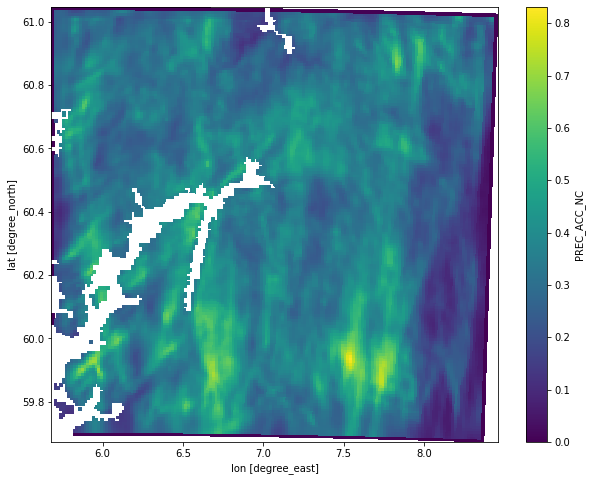

In [18]:
fig = plt.figure(figsize=(10, 8))

prc_mean.where(da_mask.values == 1).plot(x='lon', y='lat')

Further reading:
https://www.unidata.ucar.edu/blogs/developer/en/entry/wrf_goes_cf_two